## Install Dependencies and Stable Baselines Using Pip

List of full dependencies can be found in the [README](https://github.com/hill-a/stable-baselines).

```
sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev
```


```
pip install stable-baselines[mpi]
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install keras==2.3.1

     |████████████████████████████████| 378kB 13.2MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
# Stable Baselines only supports tensorflow 1.x for now
#!pip install tensorflow==1.13.2
%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 0s (6,990 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.8) ...
Setting up xvfb (2:1.19.6-1ubuntu4.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 2

## Imports

In [4]:
import gym
import pickle
#import torch as th
#import torch.nn as nn
import os
import time

import stable_baselines
stable_baselines.__version__
from stable_baselines import PPO2
from stable_baselines.common.callbacks import BaseCallback

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Limpando pastas locais

In [5]:
#!rm -rf logs
#!rm -rf results
#!rm -rf videos

## Resolvendo os problemas da seed

In [6]:
seed_value = 12345

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
#seed_value += 1

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
#seed_value += 1

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
#seed_value += 1

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)



# 5. Configure a new global `tensorflow` session
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)

## Parâmetros e paths

In [7]:
# AQUI
agent = 'PPO-cartPole'
enviroment = 'CartPole-v1'

timestr = time.strftime("%Y%m%d-%H%M%S")

experiment_name = agent + '_' + timestr

os.makedirs(experiment_name)

results_path = experiment_name + '/results_' + experiment_name
logdir = experiment_name + '/logs_' + experiment_name
videodir = experiment_name + '/videos_' + experiment_name

os.makedirs(results_path)
os.makedirs(logdir)
os.makedirs(videodir)


param_model = {
    'max_grad_norm': 0.5, 
    'lam': 0.95, 
    'cliprange': 0.2, 
    'cliprange_vf': None,
    'vf_coef':0.5,
    'learning_rate':0.00025,
    'ent_coef': 0.01,
    'n_steps': 128,
    'gamma': 0.99,
    'noptepochs': 30,
    'nminibatches': 4,
    'verbose': 1, 
    'seed': seed_value, 
    'n_cpu_tf_sess': 1
    }

param_learning = {
    'total_timesteps': 6000,
    'callback': None,
    'log_interval': 10
}


log = {**param_model, **param_learning}



## Implementação de callbacks e evaluate

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    win = 0
    loss = 0
    for i in range(num_episodes):
        #print(f'episode {i}')
        episode_rewards = []
        done = False
        lives = 0
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs, deterministic = True)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
             
        all_episode_rewards.append(sum(episode_rewards))
        if (all_episode_rewards[-1] >= 350):
          win += 1
        else:
          loss += 1 

        #print(f'reward total: {all_episode_rewards[-1]}')
    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)
  
    return all_episode_rewards, win, loss

## Políticas customizadas aqui

In [9]:
import tensorflow as tf

net_simple = [32, 32, 32]

net_medium = [64, 64, 64]

net_complex = [128, dict(pi=[32, 32], vf=[32, 32])]

##### MUDAR A POLITICA AQUI - opcoes: net_complex e net_simple
net_use = net_complex


param_model['policy_kwargs'] = dict(act_fun=tf.nn.tanh, net_arch=net_use)

log['activation_fun'] = 'tanh'
log['net_arch'] = net_use
policy_name = 'MlpPolicy'   

## Model and Train

Wrapping the env in a DummyVecEnv.


Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Mean reward: 32.46 Num episodes: 100


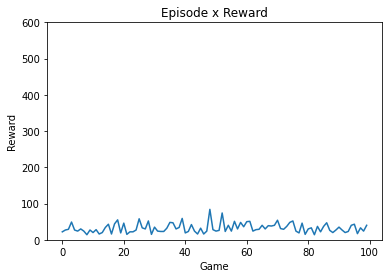

In [10]:
import matplotlib.pyplot as plt
from stable_baselines.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
import time

env = gym.make(enviroment)
env.seed(seed_value)

eval_env = gym.make(enviroment)
env.seed(seed_value)

callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=500, verbose=1)
best_model_path = os.path.join(results_path, 'best_model')
eval_callback = EvalCallback(eval_env, best_model_save_path=best_model_path,
                             log_path=logdir, eval_freq=100,
                             callback_on_new_best=callback_on_best,
                             deterministic=True, render=False)

param_learning['callback'] = eval_callback

#PASSA O POLICY NAME  
ppo_model = PPO2(policy_name, env, **param_model, tensorboard_log=logdir)

ppo_model.set_random_seed(seed=seed_value)

# Random Agent, before training
all_episode_reward_before_train, win, loss = evaluate(ppo_model, num_episodes=100)

log['all_reward_before_train'] = all_episode_reward_before_train

plt.plot(all_episode_reward_before_train)
plt.ylabel('Reward')
plt.xlabel('Game')
plt.title('Episode x Reward')
plt.ylim(0, 600)
plt.show()

In [11]:

#### Treina
start_time = time.time()
ppo_model.learn(**param_learning)
log['time'] = (time.time() - start_time) 
print('Fininsh --- %s seconds --- ' % log['time'])



Eval num_timesteps=100, episode_reward=28.60 +/- 11.84
Episode length: 28.60 +/- 11.84
New best mean reward!

------------------------------------
| approxkl           | 0.006662807 |
| clipfrac           | 0.090885416 |
| explained_variance | -0.0158     |
| fps                | 147         |
| n_updates          | 1           |
| policy_entropy     | 0.6869145   |
| policy_loss        | -0.02128842 |
| serial_timesteps   | 128         |
| time_elapsed       | 2.74e-05    |
| total_timesteps    | 128         |
| value_loss         | 45.545734   |
------------------------------------
Eval num_timesteps=200, episode_reward=72.60 +/- 21.17
Episode length: 72.60 +/- 21.17
New best mean reward!
Eval num_timesteps=300, episode_reward=57.80 +/- 15.20
Episode length: 57.80 +/- 15.20
Eval num_timesteps=400, episode_reward=170.20 +/- 66.14
Episode length: 170.20 +/- 66.14
New best mean reward!
Eval num_timesteps=500, episode_reward=345.00 +/- 88.87
Episode length: 345.00 +/- 88.87
New best mea

## Avaliando o agente treinado

Mean reward: 500.0 Num episodes: 100


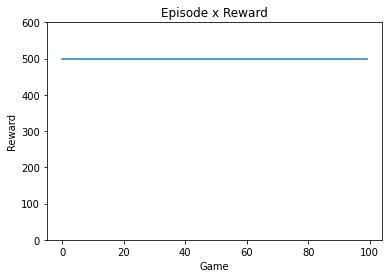

Mean reward: 500.0 Std reward: 0.0
win: 100 loss: 0


In [12]:
log['rewards'], log['win'], log['loss']  = evaluate(ppo_model, num_episodes=100)
log['mean'] = np.mean(log['rewards'])
log['std'] = np.std(log['rewards'])

plt.plot(log['rewards'])
plt.ylabel('Reward')
plt.xlabel('Game')
plt.title('Episode x Reward')
plt.ylim(0, 600)
plt.show()

print("Mean reward:", log['mean'], "Std reward:", log['std'])
print("win:", log['win'], "loss:", log['loss'])


## Funções auxiliares para video


In [13]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [14]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', name=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(name)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [15]:
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=1000, prefix='', video_folder= videodir):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(enviroment)])
  # Start the video at step=0 and record X steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

### Visualizando o agente treinado

In [16]:
def save_log(log, agent, path, experiment_name):
  #path = os.path.abspath(os.getcwd())
  #path = os.path.join(path, 'results')
  print('Save log in %s ' % path)
  #timestr = time.strftime("%Y%m%d-%H%M%S")
  name_file = experiment_name + '.pkl'
  name_file = os.path.join(path, name_file)
  if not os.path.exists(path):
      os.makedirs(path)
  a_file = open(name_file, "wb")
  pickle.dump(log, a_file)
  a_file.close()

  name_file = experiment_name
  #salvando o video
  record_video(enviroment, ppo_model, video_length=6000, prefix=name_file, video_folder=videodir)
  print('video - Saving local')
  #mostrando o video salvo
  show_videos(videodir, name=name_file)


In [ ]:
save_log(log, agent, results_path, experiment_name)

Save log in PPO-cartPole_20210125-184944/results_PPO-cartPole_20210125-184944 


## TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir "$experiment_name"/logs_"$experiment_name"

In [ ]:
!cp -r "$experiment_name" /content/drive/MyDrive/T2_ReinforcementLearning/Results/

In [ ]:
#!tensorboard dev upload \
#  --logdir logs \
#  --name "(optional) My latest experiment" \
#  --description "(optional) Simple comparison of several hyperparameters" \
#  --one_shot